### Homework 2: Simple Spread Trading - Hengxu Zhu 12368409

## Import Packages

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import datetime
from statsmodels.tsa.ar_model import AutoReg 
import warnings
warnings.filterwarnings('ignore')

## Load Data

### ETF Pair: PBE & XBI

In [2]:
quandl.ApiConfig.api_key = '_MNv7zC_784tGzbfxhxP'

In [3]:
def get_quandl_data(ticker, start, end, n): 
    x = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ticker, date = {'gte': start, 'lte': end}) 
    df = x[['adj_close', 'adj_volume']]
    df.index = x['date'] 
    df = df.sort_index() 
    df[ticker + '_est_dollar_volume'] = df['adj_volume'].rolling(n).median().shift(1) * df['adj_close'] 
    df = df.drop(columns = ['adj_volume']) 
    df = df.rename(columns={'adj_close': ticker + '_adj_close'})
    return df            

In [4]:
start = '2020-12-02' 
end = '2022-11-15' 
ticker1 = 'PBE' 
ticker2 = 'XBI'
x = get_quandl_data(ticker1, start, end, 15) 
y = get_quandl_data(ticker2, start, end, 15) 
quandl_data = x.merge(y, right_index=True, left_index=True) 
quandl_data['$N_{t}$'] = np.where((quandl_data['PBE_est_dollar_volume'] > quandl_data['XBI_est_dollar_volume']), 
                             quandl_data['XBI_est_dollar_volume'], quandl_data['PBE_est_dollar_volume']) 
quandl_data = quandl_data.drop(columns=['PBE_est_dollar_volume', 'XBI_est_dollar_volume']) 
quandl_data['2020-12-25':'2021-01-05']

,PBE_adj_close,XBI_adj_close,$N_{t}$
date,,,
2020-12-28,71.3619,146.420190,376434.0225
2020-12-29,70.2861,142.131356,386432.9778
2020-12-30,70.9201,144.040837,400840.4052
2020-12-31,70.1308,140.741734,396379.2816
2021-01-04,70.3640,140.911688,397697.3280
2021-01-05,70.8250,140.411824,404269.1000


### Fama-French Data

In [5]:
df = pd.read_csv('Developed_3_Factors_Daily.csv', header = 7) 
df['Date'] = pd.to_datetime(df['Unnamed: 0'].astype(str), format='%Y%m%d')
FF3 = df[['Mkt-RF', 'SMB', 'HML', 'RF']]
FF3.index = df['Date'] 
FF3 = FF3[start:end]
FF3

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-12-02,0.21,-0.14,0.86,0.00
2020-12-03,0.28,0.37,0.40,0.00
2020-12-04,0.70,0.13,0.81,0.00
2020-12-07,-0.13,-0.18,-0.40,0.00
2020-12-08,0.27,0.36,-0.56,0.00
...,...,...,...,...
2022-11-09,-1.76,0.04,0.17,0.01
2022-11-10,5.03,-0.10,-2.36,0.01
2022-11-11,1.61,1.06,-1.55,0.01


## Implement Strategy 

In [6]:
K = int(round(2*quandl_data['$N_{t}$'].max()/100, 0))
K

21064

In [7]:
def initiate_trading_tracker(M): 
    trading_tracker = quandl_data.copy()
    trading_tracker['PBE_return'] = trading_tracker['PBE_adj_close'].pct_change(M)
    trading_tracker['XBI_return'] = trading_tracker['XBI_adj_close'].pct_change(M)
    trading_tracker['return_diff'] = trading_tracker['PBE_return'] - trading_tracker['XBI_return'] 
    trading_tracker['PBE_position'] = 0 
    trading_tracker['XBI_position'] = 0 
    trading_tracker['sign'] = 0 
    trading_tracker['PnL'] = 0.0 
    trading_tracker['cum_PnL'] = 0.0 
    trading_tracker = trading_tracker['2021':] 
    return trading_tracker 

This function intends to create a tracker that we can use to track the trading process by updating each row in a loop.

In [8]:
tracker = initiate_trading_tracker(10) 

In [9]:
def spread_trading(df, g, j, s): 
    
    gross_traded_cash = 0
    stop_loss = False
    
    for i in range(len(df)): 
        
        if i == 0 or abs(df['return_diff'][i]) > g and stop_loss == False: 
            
            if (df['PBE_position'][i-1] == 0 and df['XBI_position'][i-1] == 0): # enter 
                sign = np.sign(df['return_diff'][i]) 
                df['sign'][i] = sign 
                amount = df['$N_{t}$'][i] / 100 
                PBE_shares = int(round(amount / df['PBE_adj_close'][i], 0)) 
                XBI_shares = int(round(amount / df['XBI_adj_close'][i], 0)) 
                df['PBE_position'][i] = -1 * sign * PBE_shares 
                df['XBI_position'][i] = sign * XBI_shares 
                df['PnL'][i] = 0 
                if i != 0: 
                    df['cum_PnL'][i] = df['cum_PnL'][i-1] 
                else: 
                    df['cum_PnL'][i] = 0
                gross_traded_cash = PBE_shares * df['PBE_adj_close'][i] + XBI_shares * df['XBI_adj_close'][i] 
            
            elif df['sign'][i] != df['sign'][i-1]: # flip 
                pnl = ((df['PBE_position'][i-1] * (df['PBE_adj_close'][i] - df['PBE_adj_close'][i-1])) 
                    + (df['XBI_position'][i-1] *(df['XBI_adj_close'][i] - df['XBI_adj_close'][i-1]))) 
                df['PnL'][i] = pnl 
                df['cum_PnL'][i] = df['cum_PnL'][i-1] + pnl 
                sign = np.sign(df['return_diff'][i]) 
                df['sign'][i] = sign 
                amount = df['$N_{t}$'][i] / 100 
                PBE_shares = int(round(amount / df['PBE_adj_close'][i], 0)) 
                XBI_shares = int(round(amount / df['XBI_adj_close'][i], 0)) 
                df['PBE_position'][i] = -1 * sign * PBE_shares 
                df['XBI_position'][i] = sign * XBI_shares 
                gross_traded_cash = PBE_shares * df['PBE_adj_close'][i] + XBI_shares * df['XBI_adj_close'][i] 
        
        elif abs(df['return_diff'][i]) < j and stop_loss == False: # end of month exit 
            if df.index[i-1].month < df.index[i].month or i == len(df)-1: 
                stop_loss = False 
            pnl = ((df['PBE_position'][i-1] * (df['PBE_adj_close'][i] - df['PBE_adj_close'][i-1])) 
                    + (df['XBI_position'][i-1] *(df['XBI_adj_close'][i] - df['XBI_adj_close'][i-1]))) 
            df['PnL'][i] = pnl 
            df['cum_PnL'][i] = df['cum_PnL'][i-1] + pnl 
            df['sign'][i] = 0
            df['PBE_position'][i] = 0 
            df['XBI_position'][i] = 0 
            
        else: # maintain 
            df['PBE_position'][i] = df['PBE_position'][i-1] 
            df['XBI_position'][i] = df['XBI_position'][i-1] 
            pnl = ((df['PBE_position'][i] * (df['PBE_adj_close'][i] - df['PBE_adj_close'][i-1])) 
                + (df['XBI_position'][i] *(df['XBI_adj_close'][i] - df['XBI_adj_close'][i-1]))) 
            df['PnL'][i] = pnl 
            df['cum_PnL'][i] = df['cum_PnL'][i-1] + pnl 
            df['sign'][i] = df['sign'][i-1] 
            
        if gross_traded_cash * s < PBE_shares * df['PBE_adj_close'][i] - XBI_shares * df['XBI_adj_close'][i]: 
            pnl = ((df['PBE_position'][i-1] * (df['PBE_adj_close'][i] - df['PBE_adj_close'][i-1])) + (df['XBI_position'][i-1] *(df['XBI_adj_close'][i] - df['XBI_adj_close'][i-1]))) 
            df['PnL'][i] = pnl 
            df['cum_PnL'][i] = df['cum_PnL'][i-1] + pnl 
            df['sign'][i] = 0
            df['PBE_position'][i] = 0 
            df['XBI_position'][i] = 0 
            stop_loss = True
            
    return df

This strategy basically contains the following part: 

Note: the initial spread return is calculated as X - Y or PBE - XBI. 
1. Enter: we buy/short the spread when the magnitude(or abusolute value) of the spread return is great than g. In specific, if the spread return is positive, then we short PBE and buy XBI as we anticipate this spread return should fall according to the spread trading assumptions. If spread return is negative, that means the return is lower than -g, then we buy PBE and short XBI. 
2. Exit: under the same mechanism as enter, we exit the spread postion and hold/short nothing when the magnitude(or abusolute value) of the spread return is less than j. 
3. Maintain: we maintain the position from last time point if we have the magnitude(or abusolute value) of the spread return continues to be great than g or greater than j. This means if we have a return that is greater than j and less than g, we will maintain. 
4. Stop loss: we exit our position when the current position value is greater than a certain portion(s) gross traded cash. This action will keep until month end. 

In [10]:
g = np.quantile(tracker['return_diff'], 0.9) 
j = np.quantile(tracker['return_diff'], 0.6)
s = 0.5
trading_simulation1 = spread_trading(tracker, g, j, s) 

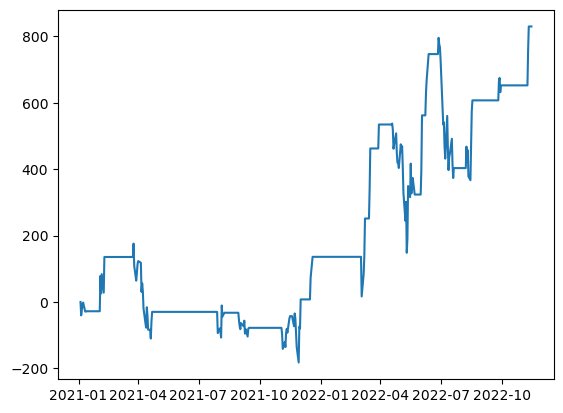

In [11]:
plt.plot(trading_simulation1['cum_PnL']) 

In [12]:
g = np.quantile(tracker['return_diff'], 0.9) 
j = np.quantile(tracker['return_diff'], 0.7)
s = 0.5
trading_simulation2 = spread_trading(tracker, g, j, s) 

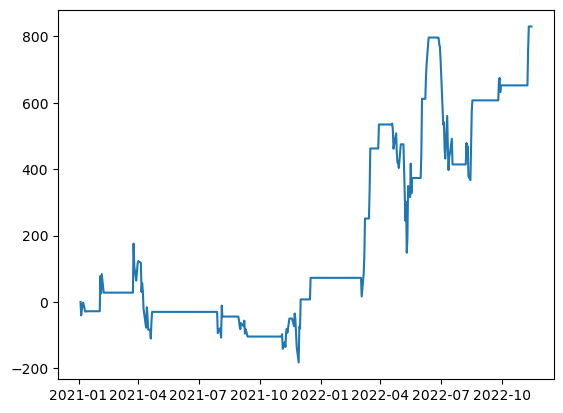

In [13]:
plt.plot(trading_simulation2['cum_PnL']) 

In [14]:
g = np.quantile(tracker['return_diff'], 0.8) 
j = np.quantile(tracker['return_diff'], 0.6)
s = 0.5
trading_simulation3 = spread_trading(tracker, g, j, s) 

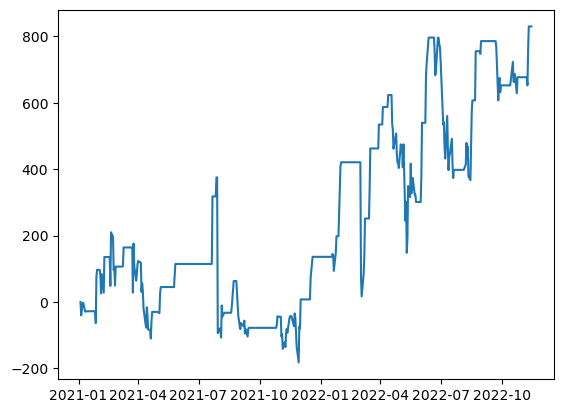

In [15]:
plt.plot(trading_simulation3['cum_PnL']) 

In [16]:
g = np.quantile(tracker['return_diff'], 0.8) 
j = np.quantile(tracker['return_diff'], 0.7)
s = 0.5
trading_simulation4 = spread_trading(tracker, g, j, s) 

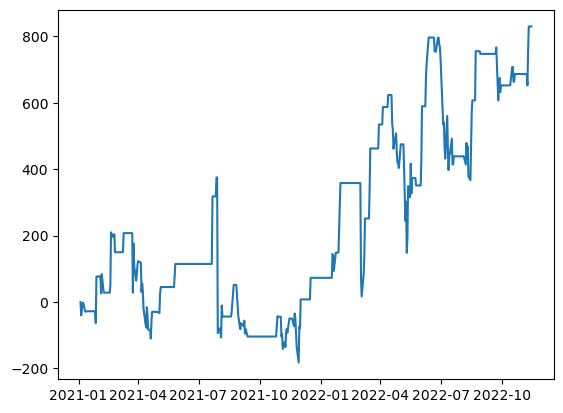

In [17]:
plt.plot(trading_simulation4['cum_PnL']) 

After trying different options of M, I found that 10 days rolling window will give the most steady growth of the cumulative return. We chose 0.5 for s as it does not affect the result so heavily unless it is too small. We tried 4 combos of g and j. They are combinations of g = 90/80 percentile and j = 70/60 percentile of the spread returns. It appears that when g-j is narrow, the graph will be more volatile and this is easy to explain as we need to update positions more frequently when g-j is small. Also, when g is large, we have the graph more stable. Since when g is large, we are hard to exit a position after we enter it. 

## Analysis 

In [18]:
def summary_stat(data): 
    
    summary_stats = data.mean().to_frame('Mean').round(2)
    summary_stats['Volatility'] = data.std().round(2)
    summary_stats['Sharpe Ratio'] = (summary_stats['Mean'] / summary_stats['Volatility']).round(2) 
    
    summary_stats['Min'] = data.min().round(2)
    summary_stats['25% Quantile'] = data.quantile(0.25, axis = 0)
    summary_stats['Median'] = data.median()
    summary_stats['75% Quantile'] = data.quantile(0.75, axis = 0)
    summary_stats['Max'] = data.max().round(2) 

    summary_stats['Skewness'] = data.skew().round(2)
    summary_stats['Kurtosis'] = data.kurtosis().round(2) 
    
    return summary_stats 

In [19]:
pnl = (trading_simulation1['cum_PnL']).to_frame()
summary_stat(pnl)

,Mean,Volatility,Sharpe Ratio,Min,25% Quantile,Median,75% Quantile,Max,Skewness,Kurtosis
cum_PnL,244.91,286.22,0.86,-182.27,7.752716,120.767566,462.603016,830.17,0.51,-1.08


The Sharpe Ratio for this strategy seems appealling and the overall profit from 2021 to 2022 is satisfying. Although from the graph, we may notice that we are losing money for the most of the time in 2021. As long as we can keep holding the position, we will get some benefit from this trading strategy. 

From the quantile values and the skewness, we can tell there is a right tail. But there might not be so much tail risk as skewness is not so large. In addition, the kurtosis also indicates a peak compared to normal distribution. 

In [20]:
mdd_data = trading_simulation1[['cum_PnL']]
mdd_data = mdd_data.replace(0, np.nan)
mdd_data = mdd_data.dropna()
previous_peaks = mdd_data.cummax()
drawdowns = mdd_data - previous_peaks
drawdowns.min().to_frame(name = 'Max Drawdown')

,Max Drawdown
cum_PnL,-557.6394


The max drawdown indicates that we experienced significant amount of loss and this makes us to believe more about actively performing this strategy and keeping it for a long period to secure a profit. 

In [21]:
FF3_and_trading_return = pnl.join(FF3) 

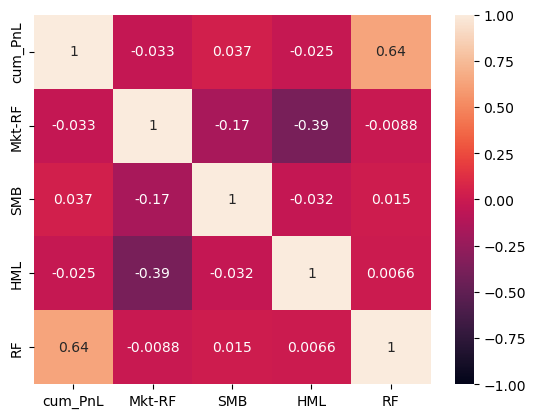

In [22]:
heatmap = sns.heatmap(FF3_and_trading_return.corr(), vmin=-1, vmax=1, annot=True) 

From the heat map, we noticed that this strategy has low correlation or even negative correlation to the Fama-French factors. Therefore, we may say this is a strategy that can not be explained by this model. From a different perspective, since we know that the Fama-French model is a theory that may not provide us high profit in the market nowadays, a low correlation might indicate we discovered a new strategy with high returns, but at the same time, large uncertainties about its effectiveness. 

## Conclusion

From this excercise, I understand how to switch back and forth of two securities to seek for profit. If I would like to make this strategy better, I will take more parameters other than just g and j, since the spread return does not follow a perfect normal distribution or even have a mean of 0. It will make more sense if we choose more parameter based on the 20-80 and 40-60 quantiles. 